In [3]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks/ANN')

Mounted at /content/drive


In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from nim_env import NimEnv, OptimalPlayer
import helpers as h

import torch
import WarningFunctions as wf


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#parameters
GAMMA = 0.99
buffer_size = 10000
BATCH_SIZE = 64
TARGET_UPDATE = 500


#-------------------------------- helpers DQN ----------------------------



# 3.2


Question 11

New game :  0
New game :  250
New game :  500
New game :  750
New game :  1000
New game :  1250
New game :  1500
New game :  1750


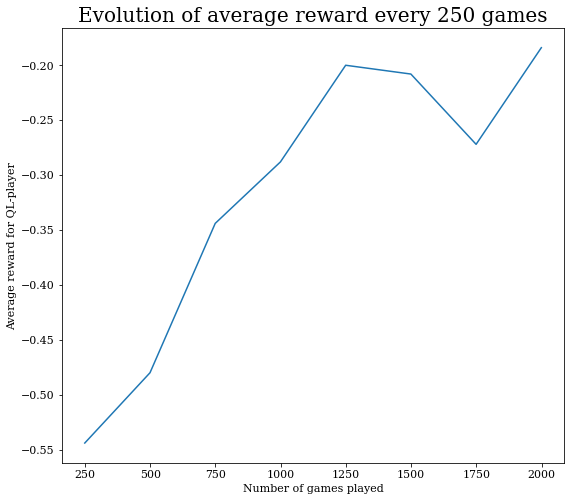

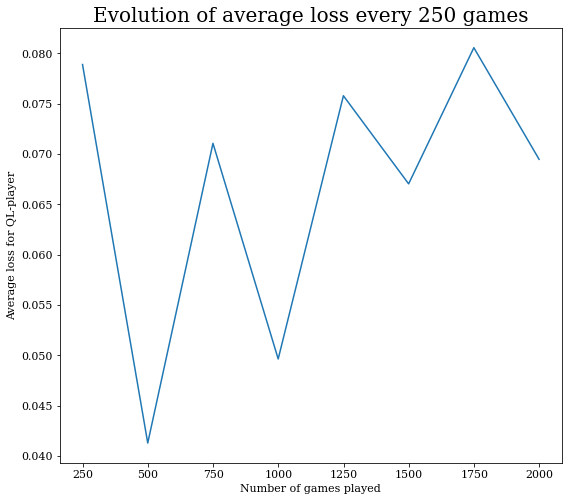

In [4]:
policy_net = h.DQN().to(device)
target_net = h.DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
memory = h.ReplayMemory(buffer_size)
h.Q11(policy_net, target_net, memory, eps = 0.1, eps_opt = 0.5, nb_games=2000, save = False)

Question 12


New game :  0


/Users/Anya48/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:972: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


New game :  250
New game :  500
New game :  750
New game :  1000
New game :  1250
New game :  1500
New game :  1750


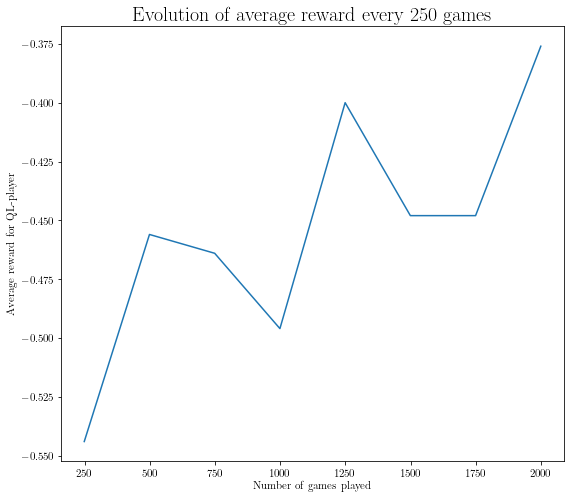

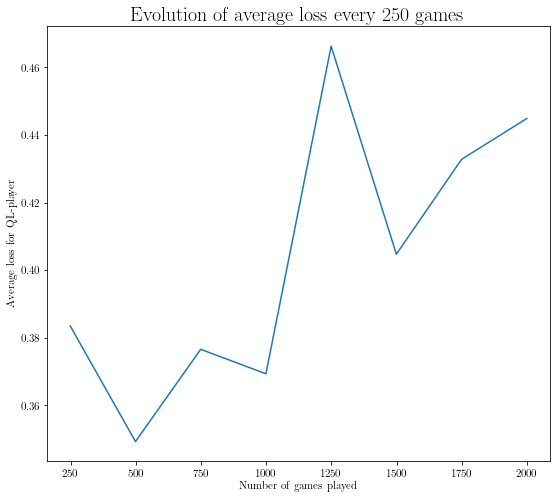

In [ ]:
policy_net = h.DQN().to(device)
target_net = h.DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
memory = h.Memory_Q12()
h.Q12(policy_net, target_net, memory, eps = 0.1, eps_opt = 0.5, nb_games=2000, question='q3-12')

Question 13

In [ ]:
def Q13_a(N_star, nb_games = 20000, eps_min = 0.1, eps_max = 0.8,  GAMMA = 0.99, buffer_size = 10000, BATCH_SIZE = 64, TARGET_UPDATE = 500,
       step = 250, seed = None, question = 'q3-13a', nb_samples = 5, save = True):
    """
    Implements the solution to the 13th question
    - inputs: 
        - N_star: a list containing the values of n*, dtype: list
        - nb_games: the number of games to play. Default: 20000, dtype: int
        - eps_min: the minimal value for the exploration level of the QL-player. Default: 0.1, dtype: float
        - eps_max: the maximal value for the exploration level of the QL-player. Default: 0.8, dtype: float
        - alpha: learning rate of the QL-player. Default: 0.1, dtype: float
        - gamma: discount factor of the QL-player. Default: 0.99, dtype: float
        - step: number of games to play before calculating the average reward. Default: 250, dtype: int
        - seed: the user can set a given seed for reproducibility. Default: None
        - question: string used to differentiate between the plots for each question. 
            Only used if 'save' is True. Default: 'q2-3', dtype: str
        - nb_samples: if this number is higher than 1, the 'nb_games' are played several times and then averaged in order to take into account the schocasticity of te problem. Default: 5, dtype: int
        - save: if set to False, the plots are only displayed but not saved. Default: True, dtype: bool
    - outputs: 
        - a figure with a plot for each n* representing the average reward every 'step' games for the QL-player. According to the value of the argument 'nb_samples', two different figures can be produced. Figures are saved in a folder Data if the argument 'save' is set to True.
        - returns the final rewards for each n* as a dictionnary
    """
    #wf.Q2_warning(N_star, nb_games, eps_min, eps_max, alpha, gamma, step, question, nb_samples, save)
    
    plt.figure(figsize = (9, 8))
    legend = []
    Final_rewards = {}
    for j, n_star in enumerate(N_star):
        Rewards = np.zeros(int(nb_games / step))
        Steps = np.zeros(int(nb_games / step))
        Losses = np.zeros(int(nb_games / step))
        for s in range(nb_samples):
            env = NimEnv(seed = seed)
            eps = max(eps_min, eps_max * (1 - 1 / n_star))
            playerOpt = OptimalPlayer(epsilon = 0.5, player = 0)
            policy_net = h.DQN().to(device)
            target_net = h.DQN().to(device)
            target_net.load_state_dict(policy_net.state_dict())
            target_net.eval()
            memory = h.ReplayMemory(buffer_size)
            playerDQN = h.DQN_Player(player = 1, policy_net = policy_net, target_net= target_net, memory=memory,
                                     EPS_GREEDY = eps, GAMMA = GAMMA, buffer_size = buffer_size,
                                    BATCH_SIZE = BATCH_SIZE, TARGET_UPDATE = TARGET_UPDATE) 
            total_reward = 0.0
            total_loss = 0.0
            for i in range(nb_games):
                # switch turns at every game
                if i % 2 == 0:
                    playerOpt.player = 0
                    playerDQN.player = 1
                else:
                    playerOpt.player = 1
                    playerDQN.player = 0
        
                new_reward, new_loss = h.DQN_one_game(playerDQN, playerOpt, env)
                total_reward += new_reward
                if new_loss != None: #the loss might be None if the opt. player directly wins.
                    total_loss += new_loss
                if i % step == step - 1:
                    Rewards[i // step] += total_reward / step
                    Losses[i // step] += total_loss / step
                    total_reward = 0.
                    total_loss = 0.
                    Steps[i // step] = i
                env.reset(seed = seed)
                playerDQN.EPS_GREEDY = max(eps_min, eps_max * (1 - (i + 2) / n_star)) # change eps for the next game (current game is (i+1))
        Rewards = Rewards / nb_samples
        plt.plot(Steps, Rewards)
        Final_rewards['{}'.format(n_star)] = Rewards[-1]
        legend.append(r"$n_* = {}$".format(n_star))
    plt.legend(legend)
    plt.title('Evolution of average reward with decrease of exploration level')
    plt.xlabel('Number of games played')
    plt.ylabel('Average reward for DQN-player')
    if save:
        if nb_samples > 1:
            plt.savefig('./Data/' + question + '_' + str(nb_samples) + '_samples.png')
        else:
            plt.savefig('./Data/' + question + '.png')
    return Final_rewards

def Q13_b(N_star, nb_games = 20000, eps_min = 0.1, eps_max = 0.8, GAMMA = 0.99, buffer_size = 10000, BATCH_SIZE = 64, TARGET_UPDATE = 500,
        step = 250, seed = None, question = 'q3-13b', nb_samples = 5, save = True):
    
    """
    Implements the solution to the 4th question
    - inputs: 
        - Eps_opt: a list containing the values of different eps_opt for the optimal player. dtype: list of floats
        - n_star: the value of n* found in the previous questions to be the best for the QL-player. Default: 1000, dtype: int
        - nb_games: the number of games to play. Default: 20000, dtype: int
        - eps_min: the minimal value for the exploration level of the QL-player. Default: 0.1, dtype: float
        - eps_max: the maximal value for the exploration level of the QL-player. Default: 0.8, dtype: float
        - alpha: learning rate of the QL-player. Default: 0.1, dtype: float
        - gamma: discount factor of the QL-player. Default: 0.99, dtype: float
        - step: number of games to play before calculating the average reward. Default: 250, dtype: int
        - seed: the user can set a given seed for reproducibility. Default: None
        - question: string used to differentiate between the plots for each question. 
            Only used if 'save' is True. Default: 'q2-4', dtype: str
        - nb_samples: if this number is higher than 1, the 'nb_games' are played several times and then averaged in order to take into account the schocasticity of te problem. Default: 5, dtype: int
        - save: if set to False, the plots are only displayed but not saved. Default: True, dtype: bool
    - outputs: 
        - a figure with two subplots representing respectively the performance against the optimal player (Mopt) and against a totally random player (Mrand) with a plot for each n*. The performance is averaged on 500 games played 5 times to take stochasticity into account. 
        According the the value of the argument 'nb_samples', two different figures can be produced. Figures are saved in a folder Data if the argument 'save' is set to True.
        - returns the final Mopt, Mrand for each n* as two dictionnaries
    """

    #wf.Q4_warning(Eps_opt, n_star, nb_games, eps_min, eps_max, alpha, gamma, step, question, nb_samples, save)
    
    fig, axs = plt.subplots(2, 1, figsize = (9, 13))
    ax = axs[0]
    ax2 = axs[1]
    legend = []
    Final_Mopt = {}
    Final_Mrand = {}
    for j, n_star in enumerate(N_star):
        Mopt = np.zeros(int(nb_games / step))
        Mrand = np.zeros(int(nb_games / step))
        Rewards = []
        Steps = np.zeros(int(nb_games / step))
        for l in range(nb_samples):
            total_reward = 0.0
            env = NimEnv(seed = seed)
            eps = max(eps_min, eps_max * (1 - 1 / n_star)) 
            playerOpt = OptimalPlayer(epsilon = 0.5, player = 0)
            policy_net = h.DQN().to(device)
            target_net = h.DQN().to(device)
            target_net.load_state_dict(policy_net.state_dict())
            target_net.eval()
            memory = h.ReplayMemory(buffer_size)
            playerDQN = h.DQN_Player(player = 1, policy_net = policy_net, target_net= target_net, memory=memory,
                                                EPS_GREEDY = eps, GAMMA = GAMMA, buffer_size = buffer_size, BATCH_SIZE = BATCH_SIZE,
                                                TARGET_UPDATE = TARGET_UPDATE) 
            
            for i in range(nb_games):
                # switch turns at every game
                if i % 2 == 0:
                    playerOpt.player = 0
                    playerDQN.player = 1
                else:
                    playerOpt.player = 1
                    playerDQN.player = 0

                new_reward, _ = h.DQN_one_game(playerDQN, playerOpt, env)
                total_reward += new_reward

                if i % step == step - 1:
                    Rewards.append(total_reward / step)
                    Steps[i // step] = i
                    total_reward = 0.0
                    mopt = 0
                    mrand = 0
                    new_env = NimEnv()
                    for m in range(5):  # here we run for several different seeds
                        # compute M_opt
                        new_playerOpt = OptimalPlayer(epsilon = 0, player = 0)
                        for k in range(500):
                            if k % 2 == 0:
                                new_playerOpt.player = 0
                                playerDQN.player = 1
                            else:
                                new_playerOpt.player = 1
                                playerDQN.player = 0
                            new_reward_mopt, _ = h.DQN_one_game(playerDQN, new_playerOpt, new_env, update = False)
                            mopt += new_reward_mopt
                            new_env.reset()   
                
                        # compute M_rand
                        playerRand = OptimalPlayer(epsilon = 1, player = 0)
                        for k in range(500):
                            if k % 2 == 0:
                                playerRand.player = 0
                                playerDQN.player = 1
                            else:
                                playerRand.player = 1
                                playerDQN.player = 0
                            new_reward_mrand, _ = h.DQN_one_game(playerDQN, playerRand, new_env, update = False)
                            mrand += new_reward_mrand
                            new_env.reset()
                    Mrand[i // step] += mrand / (500 * 5)
                    Mopt[i // step] += mopt / (500 * 5)
                
                env.reset()
                playerDQN.EPS_GREEDY = max(eps_min, eps_max * (1 - (i + 2) / n_star)) # change eps for the next game (current game is (i+1))
        
        ax.plot(Steps, Mopt / nb_samples)
        ax2.plot(Steps, Mrand / nb_samples)
        legend.append(r"$n^* = {}$".format(n_star))
        Final_Mopt["{}".format(n_star)] = Mopt[-1] / nb_samples
        Final_Mrand["{}".format(n_star)] = Mrand[-1] / nb_samples
    
    ax.legend(legend)
    ax2.legend(legend)
    ax.set_title('Evolution of Mopt for different n*')
    ax2.set_title('Evolution of Mrand for different n*')
    ax.set_xlabel('Number of games played')
    ax2.set_xlabel('Number of games played')
    ax.set_ylabel(r'$M_{opt}$')
    ax2.set_ylabel(r'$M_{rand}$')
    if save:
        if nb_samples > 1:
            plt.savefig('./Data/' + question + '_' + str(nb_samples) + '_samples.png')
        else:
            plt.savefig('./Data/' + question + '.png')
    return Final_Mopt, Final_Mrand



In [ ]:
N_star = [1, 1000, 5000, 10000]
Q13_a(N_star, nb_games = 20000, nb_samples = 1)


In [ ]:
N_star = [1, 1000, 5000, 10000]
Q13_b(N_star, nb_games = 20000, nb_samples = 1)

Question 14

In [ ]:
def Q14(Eps_opt, n_star = 1000, nb_games = 20000, eps_min = 0.1, eps_max = 0.8, GAMMA = 0.99, buffer_size = 10000, BATCH_SIZE = 64, TARGET_UPDATE = 500,
        step = 250, seed = None, question = 'q3-14', nb_samples = 5, save = True):
    
    """
    Implements the solution to the 4th question
    - inputs: 
        - Eps_opt: a list containing the values of different eps_opt for the optimal player. dtype: list of floats
        - n_star: the value of n* found in the previous questions to be the best for the QL-player. Default: 1000, dtype: int
        - nb_games: the number of games to play. Default: 20000, dtype: int
        - eps_min: the minimal value for the exploration level of the QL-player. Default: 0.1, dtype: float
        - eps_max: the maximal value for the exploration level of the QL-player. Default: 0.8, dtype: float
        - alpha: learning rate of the QL-player. Default: 0.1, dtype: float
        - gamma: discount factor of the QL-player. Default: 0.99, dtype: float
        - step: number of games to play before calculating the average reward. Default: 250, dtype: int
        - seed: the user can set a given seed for reproducibility. Default: None
        - question: string used to differentiate between the plots for each question. 
            Only used if 'save' is True. Default: 'q2-4', dtype: str
        - nb_samples: if this number is higher than 1, the 'nb_games' are played several times and then averaged in order to take into account the schocasticity of te problem. Default: 5, dtype: int
        - save: if set to False, the plots are only displayed but not saved. Default: True, dtype: bool
    - outputs: 
        - a figure with two subplots representing respectively the performance against the optimal player (Mopt) and against a totally random player (Mrand) with a plot for each n*. The performance is averaged on 500 games played 5 times to take stochasticity into account. 
        According the the value of the argument 'nb_samples', two different figures can be produced. Figures are saved in a folder Data if the argument 'save' is set to True.
        - returns the final Mopt, Mrand for each n* as two dictionnaries
    """
    Eps_opt = list(Eps_opt)
    #wf.Q4_warning(Eps_opt, n_star, nb_games, eps_min, eps_max, alpha, gamma, step, question, nb_samples, save)
    
    fig, axs = plt.subplots(2, 1, figsize = (9, 13))
    ax = axs[0]
    ax2 = axs[1]
    legend = []
    Final_Mopt = {}
    Final_Mrand = {}
    for j, eps_opt in enumerate(Eps_opt):
        Mopt = np.zeros(int(nb_games / step))
        Mrand = np.zeros(int(nb_games / step))
        Rewards = []
        Steps = np.zeros(int(nb_games / step))
        for l in range(nb_samples):
            total_reward = 0.0
            env = NimEnv(seed = seed)
            eps = max(eps_min, eps_max * (1 - 1 / n_star)) 
            playerOpt = OptimalPlayer(epsilon = eps_opt, player = 0)
            policy_net = h.DQN().to(device)
            target_net = h.DQN().to(device)
            target_net.load_state_dict(policy_net.state_dict())
            target_net.eval()
            memory = h.ReplayMemory(buffer_size)
            playerDQN = h.DQN_Player(player = 1, policy_net = policy_net, target_net= target_net, memory=memory,
                                                EPS_GREEDY = eps, GAMMA = GAMMA, buffer_size = buffer_size, BATCH_SIZE = BATCH_SIZE,
                                                TARGET_UPDATE = TARGET_UPDATE) 
            
            for i in range(nb_games):
                # switch turns at every game
                if i % 2 == 0:
                    playerOpt.player = 0
                    playerDQN.player = 1
                else:
                    playerOpt.player = 1
                    playerDQN.player = 0

                new_reward, _ = h.DQN_one_game(playerDQN, playerOpt, env)
                total_reward += new_reward

                if i % step == step - 1:
                    Rewards.append(total_reward / step)
                    Steps[i // step] = i
                    total_reward = 0.0
                    mopt = 0
                    mrand = 0
                    new_env = NimEnv()
                    for m in range(5):  # here we run for several different seeds
                        # compute M_opt
                        new_playerOpt = OptimalPlayer(epsilon = 0, player = 0)
                        for k in range(500):
                            if k % 2 == 0:
                                new_playerOpt.player = 0
                                playerDQN.player = 1
                            else:
                                new_playerOpt.player = 1
                                playerDQN.player = 0
                            new_reward_mopt, _ = h.DQN_one_game(playerDQN, new_playerOpt, new_env, update = False)
                            mopt += new_reward_mopt
                            new_env.reset()   
                
                        # compute M_rand
                        playerRand = OptimalPlayer(epsilon = 1, player = 0)
                        for k in range(500):
                            if k % 2 == 0:
                                playerRand.player = 0
                                playerDQN.player = 1
                            else:
                                playerRand.player = 1
                                playerDQN.player = 0
                            new_reward_mrand, _ = h.DQN_one_game(playerDQN, playerRand, new_env, update = False)
                            mrand += new_reward_mrand
                            new_env.reset()
                    Mrand[i // step] += mrand / (500 * 5)
                    Mopt[i // step] += mopt / (500 * 5)
                
                env.reset()
                playerDQN.EPS_GREEDY = max(eps_min, eps_max * (1 - (i + 2) / n_star)) # change eps for the next game (current game is (i+1))
        
        ax.plot(Steps, Mopt / nb_samples)
        ax2.plot(Steps, Mrand / nb_samples)
        legend.append(r"$\varepsilon_o = {}$".format(eps_opt))
        Final_Mopt["{}".format(n_star)] = Mopt[-1] / nb_samples
        Final_Mrand["{}".format(n_star)] = Mrand[-1] / nb_samples
    
    ax.legend(legend)
    ax2.legend(legend)
    ax.set_title(r'Evolution of Mopt for different $\epsilon_{opt}$')
    ax2.set_title(r'Evolution of Mrand for different $\epsilon_{opt}$')
    ax.set_xlabel('Number of games played')
    ax2.set_xlabel('Number of games played')
    ax.set_ylabel(r'$M_{opt}$')
    ax2.set_ylabel(r'$M_{rand}$')
    if save:
        if nb_samples > 1:
            plt.savefig('./Data/' + question + '_' + str(nb_samples) + '_samples.png')
        else:
            plt.savefig('./Data/' + question + '.png')
    return Final_Mopt, Final_Mrand

# Q.16


In [17]:
def DQN_one_game_vs_self(player_DQN, env, update = True):
    """
    Implementation of one game of NIM of a Q-learning player (after: QL player) against itself.
    - inputs:
        - playerQL: an instance of the PlayerQL class. The idea is to then create two copies of this player 
            that will play against each other. Q-values are updated after each game for every instance 
            (the copies and the original) if update is set to True (see after).
        - eps: epsilon associated to QL player (probability of playing at random)
        - alpha: learning rate of the QL player
        - gamma: discount factor of the QL player
        - env: an instance of the class NimEnv. Setting with which the players are going to play
        - update: if set to false, the Q-values are not updated. Default: True. 
            The utility of this argument is to be able to play a game without having to update the 
            Q-values (useful when computing Mopt and Mrand)
    - output: None
    
    The idea of the update is to keep a copy of the environment before the turn of a player and after the turn of the other (heaps before and heaps_after) and also the actions played by each.
    If the game is over we need to update both the players'q-values as they both get a reward (-1 or +1).
    """
    playerDQN_1 = player_DQN.copy()
    playerDQN_2 = player_DQN.copy()

    playerDQN_1.player = 1
    playerDQN_2.player = 0

    heaps, _, _ = env.observe()
    reward = -1
    loss = None
    i = 0
    while not env.end:
        if env.current_player == playerDQN_1.player:
            move_DQN1 = playerDQN_1.act(heaps)
            state_DQN1 = h.to_input(heaps)
            is_available = env.check_valid(move_DQN1)
            if not is_available :
                #if the action is not valid, we give the agent a negative reward
                reward = torch.tensor([-1], device=device)
                next_state = None
                if update == True :
                    #print("non valid action, store ", state_DQN1, move_DQN1, next_state, reward)
                    player_DQN.memory_push(state_DQN1, move_DQN1, next_state, reward)
                    loss = player_DQN.optimize()
                    playerDQN_2.policy_net.load_state_dict(player_DQN.policy_net.state_dict())
                    playerDQN_1.policy_net.load_state_dict(player_DQN.policy_net.state_dict())

                env.end = True
            else : #if the action is valid, we make a step
                heaps, done, _ = env.step(move_DQN1)

                if done : #if the game is finished (done == True), then we give the agent a reward of 1.
                    reward = torch.tensor([1], device=device)
                    next_state = None
                    if update == True:
                        player_DQN.memory_push(state_DQN1, move_DQN1, next_state, reward)
                        loss = player_DQN.optimize()
                        playerDQN_2.policy_net.load_state_dict(player_DQN.policy_net.state_dict())
                        playerDQN_1.policy_net.load_state_dict(player_DQN.policy_net.state_dict())
                else:
                  reward = torch.tensor([env.reward(player = 0)], device=device)
                  next_state = h.to_input(heaps)
                  if i > 0 and update == True:
                    # Store the transition in memory
                    print("valid action, store ", state_DQN2, move_DQN2, next_state, reward)
                    player_DQN.memory_push(state_DQN2, move_DQN2, next_state = next_state, reward = reward)
                    loss = player_DQN.optimize()
                    playerDQN_2.policy_net.load_state_dict(player_DQN.policy_net.state_dict())
                    playerDQN_1.policy_net.load_state_dict(player_DQN.policy_net.state_dict())
            
        else:
            move_DQN2 = playerDQN_2.act(heaps)
            state_DQN2 = h.to_input(heaps)
            is_available = env.check_valid(move_DQN2)
            if not is_available :
                #if the action is not valid, we give the agent a negative reward
                reward = torch.tensor([-1], device=device)
                next_state = None
                if update == True :
                    #print("non valid action, store ", state_DQN2, move_DQN2, next_state, reward)
                    player_DQN.memory_push(state_DQN2, move_DQN2, next_state, reward)
                    loss = player_DQN.optimize()
                    playerDQN_2.policy_net.load_state_dict(player_DQN.policy_net.state_dict())
                    playerDQN_1.policy_net.load_state_dict(player_DQN.policy_net.state_dict())
                env.end = True
            else : #if the action is valid, we make a step
                heaps, done, _ = env.step(move_DQN2)
                if done : #if the game is finished (done == True), then we give the agent a reward of 1.
                    reward = torch.tensor([1], device=device)
                    next_state = None
                    if update == True:
                        player_DQN.memory_push(state_DQN2, move_DQN2, next_state, reward)
                        loss = player_DQN.optimize()
                        playerDQN_2.policy_net.load_state_dict(player_DQN.policy_net.state_dict())
                        playerDQN_1.policy_net.load_state_dict(player_DQN.policy_net.state_dict())
                else:
                  if i > 0 and update == True:
                    # Store the transition in memory
                    reward = torch.tensor([env.reward(player = playerDQN_2.player)], device=device)
                    next_state2 = h.to_input(heaps)
                    print("valid action, store ", state_DQN1, move_DQN1, next_state, reward)
                    player_DQN.memory_push(state_DQN1, move_DQN1, next_state = next_state2, reward = reward)
                    loss = player_DQN.optimize()
                    playerDQN_2.policy_net.load_state_dict(player_DQN.policy_net.state_dict())
                    playerDQN_1.policy_net.load_state_dict(player_DQN.policy_net.state_dict())

        if update == True:
          player_DQN.update_target()
          playerDQN_2.target_net.load_state_dict(player_DQN.target_net.state_dict())
          playerDQN_1.target_net.load_state_dict(player_DQN.target_net.state_dict())
        i += 1

        return reward, loss

In [18]:
policy_net = h.DQN().to(device)
target_net = h.DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
memory = h.ReplayMemory(buffer_size)
playerDQN = h.DQN_Player(player = 1, policy_net = policy_net, target_net= target_net, memory=memory, EPS_GREEDY = 0.5) 

env = NimEnv(seed = 1)

DQN_one_game_vs_self(playerDQN, env)

(-1, None)

In [19]:
def Q16_a(nb_games = 20000, eps = 0.2, step = 250, GAMMA = 0.99, buffer_size = 10000, BATCH_SIZE = 64, TARGET_UPDATE = 500, seed = None, question = 'q3-16a'):
    #plays several games with itself
    Rewards = np.zeros(int(nb_games / step))
    Steps = np.zeros(int(nb_games / step))
    Losses = np.zeros(int(nb_games / step))
    total_reward = 0.0
    total_loss = 0.0
    env = NimEnv(seed = seed)
    policy_net = h.DQN().to(device)
    target_net = h.DQN().to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    memory = h.ReplayMemory(buffer_size)
    playerDQN = h.DQN_Player(player = 1, policy_net = policy_net, target_net= target_net, memory=memory, EPS_GREEDY = eps, GAMMA = GAMMA, buffer_size = buffer_size, BATCH_SIZE = BATCH_SIZE, TARGET_UPDATE = TARGET_UPDATE) 
    for i in range(nb_games):
        if i%step ==0:
            print('New game : ', i)
        
        new_reward, new_loss = DQN_one_game_vs_self(playerDQN, env)
        total_reward += new_reward
        if new_loss != None: #the loss might be None if the opt. player directly wins.
            total_loss += new_loss
            #print("new reward : ", new_reward)
            #print("new loss : ", new_loss)
        if i % step == step - 1:
            Rewards[i // step] += total_reward / step
            Losses[i // step] += total_loss / step
            Steps[i // step] = i
            total_reward = 0.0
            total_loss = 0.0

        env.reset(seed = seed)

    plt.figure(figsize = (9, 8))
    plt.plot(Steps, Rewards)
    plt.title('Evolution of average reward every 250 games')
    plt.xlabel('Number of games played')
    plt.ylabel('Average reward for DQN-player')
    #plt.savefig('./Data/' + question + '_rewards.png')
    plt.show()

    plt.figure(figsize = (9, 8))
    plt.plot(Steps, Losses)
    plt.title('Evolution of average loss every 250 games')
    plt.xlabel('Number of games played')
    plt.ylabel('Average loss for DQN-player')
    #plt.savefig('./Data/' + question + '_losses.png')
    plt.show()

New game :  0
New game :  250
New game :  500
New game :  750
New game :  1000
New game :  1250
New game :  1500
New game :  1750


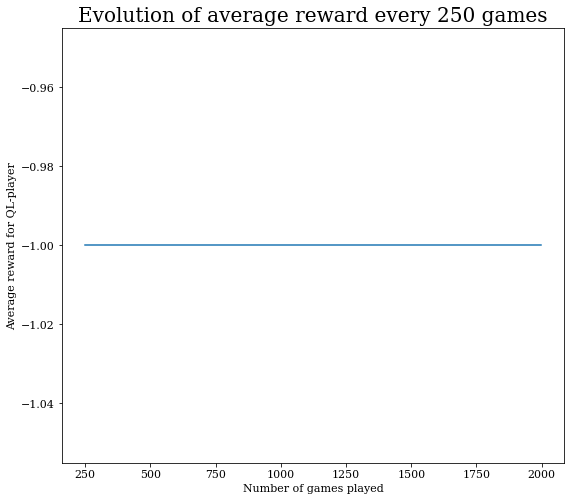

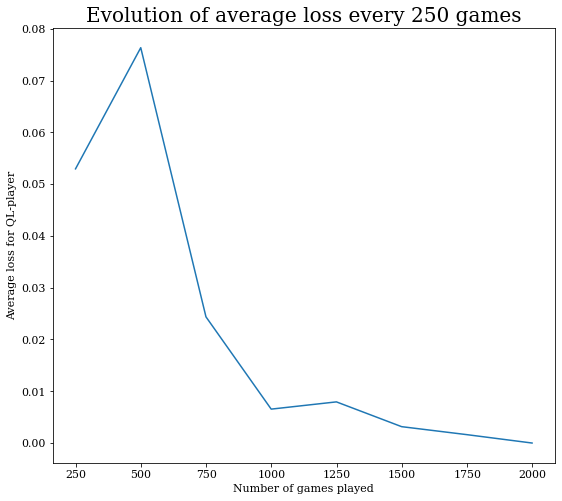

In [22]:
Q16_a(nb_games = 2000, eps = 0.1)

In [10]:
def Q16(Eps, nb_games = 20000, GAMMA = 0.99, buffer_size = 10000, BATCH_SIZE = 64, TARGET_UPDATE = 500, step = 250, seed = None, question = 'q3-16', nb_samples = 5, save = True):
    """
    Implements the solution to the 7th question. The QL-player is trained by playing against itself.
    - inputs: 
        - Eps: a list containing the values of different eps for the QL player. dtype: list of float
        - nb_games: the number of games to play. Default: 20000, dtype: int
        - alpha: learning rate of the QL-player. Default: 0.1, dtype: float
        - gamma: discount factor of the QL-player. Default: 0.99, dtype: float
        - step: number of games to play before calculating the average reward. Default: 250, dtype: int
        - seed: the user can set a given seed for reproducibility. Default: None
        - question: string used to differentiate between the plots for each question. 
            Only used if 'save' is True. Default: 'q2-7', dtype: str
        - nb_samples: if this number is higher than 1, the 'nb_games' are played several times and then averaged in order to take into account the schocasticity of te problem. Default: 5, dtype: int
        - save: if set to False, the plots are only displayed but not saved. Default: True, dtype: bool
    - outputs: 
        - a figure with two subplots representing respectively the performance against the optimal player (Mopt) and against a totally random player (Mrand) with a plot for each n*. The performance is averaged on 500 games played 5 times to take stochasticity into account. 
        According the the value of the argument 'nb_samples', two different figures can be produced. Figures are saved in a folder Data if the argument 'save' is set to True.
        - returns the final Mopt, Mrand for each n* as two dictionnaries
    """
    Eps = list(Eps)
    #wf.Q7_warning(Eps, nb_games, alpha, gamma, step, question, nb_samples, save)
    
    fig, axs = plt.subplots(2, 1, figsize = (9, 13))
    ax = axs[0]
    ax2 = axs[1]
    legend = []
    Final_Mopt = {}
    Final_Mrand = {}
    for j, eps in enumerate(Eps):
        Mopt = np.zeros(int(nb_games / step))
        Mrand = np.zeros(int(nb_games / step))
        Steps = np.zeros(int(nb_games / step))
        for l in range(nb_samples):
            env = NimEnv(seed = seed)

            policy_net = h.DQN().to(device)
            target_net = h.DQN().to(device)
            target_net.load_state_dict(policy_net.state_dict())
            target_net.eval()
            memory = h.ReplayMemory(buffer_size)
            playerDQN = h.DQN_Player(player = 0, policy_net = policy_net, target_net= target_net, memory=memory,
                                                EPS_GREEDY = eps, GAMMA = GAMMA, buffer_size = buffer_size, BATCH_SIZE = BATCH_SIZE,
                                                TARGET_UPDATE = TARGET_UPDATE)
            
            
            for i in range(nb_games):
                DQN_one_game_vs_self(playerDQN, env)
                if i % step == step - 1:
                    Steps[i // step] = i
                    total_reward = 0.0
                    mopt = 0
                    mrand = 0
                    new_env = NimEnv()
                    for m in range(5):  # here we run for several different seeds
                        # compute M_opt
                        playerOpt = OptimalPlayer(epsilon = 0, player = 0)
                        for k in range(500):
                            if k % 2 == 0:
                                playerOpt.player = 0
                                playerDQN.player = 1
                            else:
                                playerOpt.player = 1
                                playerDQN.player = 0
                            new_reward, _ = h.DQN_one_game(playerDQN, playerOpt, env = new_env, update = False)
                            mopt += new_reward
                            new_env.reset()   
                
                        # compute M_rand
                        playerRand = OptimalPlayer(epsilon = 1, player = 0)
                        for k in range(500):
                            if k % 2 == 0:
                                playerRand.player = 0
                                playerDQN.player = 1
                            else:
                                playerRand.player = 1
                                playerDQN.player = 0
                            new_reward, _ = h.DQN_one_game(playerDQN, playerRand, env = new_env, update = False)
                            mrand += new_reward
                            new_env.reset()
                    Mrand[i // step] += mrand / (500 * 5)
                    Mopt[i // step] += mopt / (500 * 5)
                
                env.reset(seed = seed)
        
        ax.plot(Steps, Mopt / nb_samples)
        ax2.plot(Steps, Mrand / nb_samples)
        legend.append(r"$\varepsilon = {}$".format(eps))
        Final_Mopt["{}".format(eps)] = Mopt[-1] / nb_samples
        Final_Mrand["{}".format(eps)] = Mrand[-1] / nb_samples
    
    ax.legend(legend)
    ax2.legend(legend)
    ax.set_title('Evolution of Mopt for different epsilon')
    ax2.set_title('Evolution of Mrand for different epsilon')
    ax.set_xlabel('Number of games played against itself')
    ax2.set_xlabel('Number of games played against itself')
    ax.set_ylabel(r'$M_{opt}$')
    ax2.set_ylabel(r'$M_{rand}$')
    if save:
        if nb_samples > 1:
            plt.savefig('./Data/' + question + '_' + str(nb_samples) + '_samples.png')
        else:
            plt.savefig('./Data/' + question + '.png')
    return Final_Mopt, Final_Mrand

KeyboardInterrupt: ignored

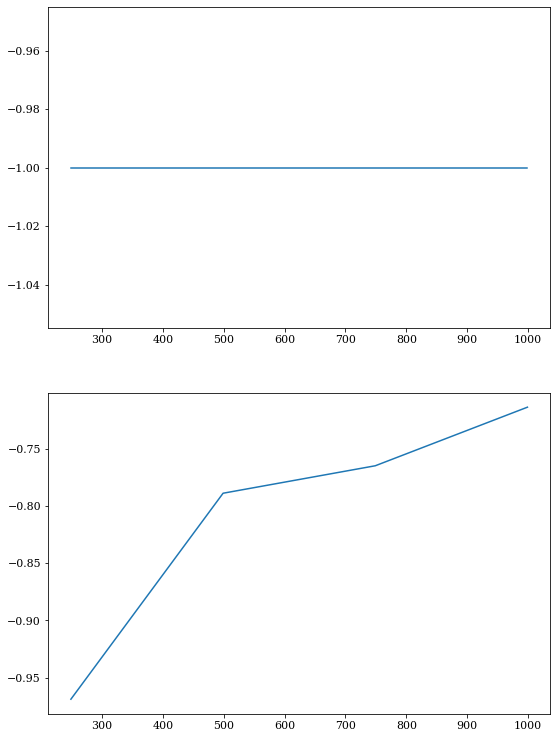

In [11]:
Eps = np.arange(0.2, 1.2, 0.2)
Q16(Eps, nb_games = 1000,  nb_samples = 1, save = False)